## Task 4 (Churn Prediction Model) and Task 5 (Model Evaluation and Interpretation)

In [23]:
# Import Libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn import metrics

warnings.simplefilter('ignore')

### Data Preparation

In [2]:
# Create a wrangle function for data cleaning
def wrangle (filepath):
    df = pd.read_csv(filepath)
    
    # Remove duplicate rows
    df = df.drop_duplicates()
    
    # Fill missing values in 'TotalCharges' with the mean
    df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

    return df

In [3]:
# Import and Wrangle CSV file
df = wrangle(r"C:\Users\GREAT\Downloads\Telco_Customer_Churn_Dataset  (3) - Telco_Customer_Churn_Dataset  (3).csv")
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Inspect data after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Check Unique values in each column
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [6]:
# Drop customerID column
df.drop(columns = ['customerID'], axis = 1, inplace = True)
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
# Convert 'SeniorCitizen' column back to a binary column
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [8]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [9]:
#  Binary Columns List
bin_cols = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','PaperlessBilling','Churn']

# Categorical Columns List
cat_cols = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup', 'Contract',
                    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaymentMethod']

# Numerical Columns List
num_cols = ['tenure','MonthlyCharges','TotalCharges']

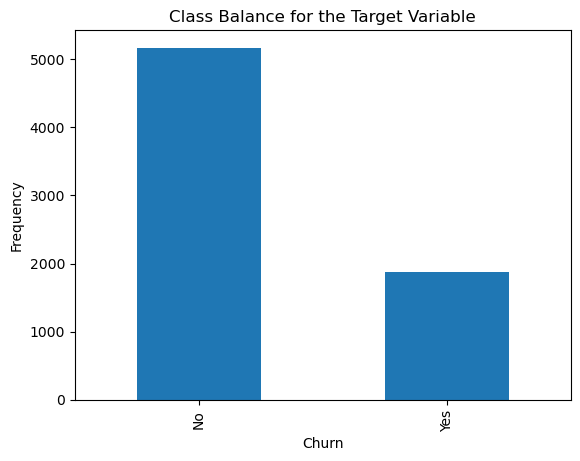

In [10]:
# Class Balance
df['Churn'].value_counts().plot(
    kind = 'bar',
    ylabel = 'Frequency',
    title = 'Class Balance for the Target Variable'
);

###  Data Preprocessing

In [11]:
# Label Encode binary columns
le = LabelEncoder()
for col in bin_cols:
    df[col] = le.fit_transform(df[col])

# Standardize Numerical Columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# One Hot Encode Categorical Columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Covert Booleans to Numbers
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

#Inpect final dataset
pd.set_option('display.max_columns',100)
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,Contract_One year,Contract_Two year,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.277445,0,1,-1.160323,-0.994971,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0.066327,1,0,-0.259629,-0.173876,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [12]:
# Correlation with Churn
corr = df.corr().abs()
corr['Churn'].sort_values(ascending=False).head(15)

Churn                                   1.000000
tenure                                  0.352229
InternetService_Fiber optic             0.308020
Contract_Two year                       0.302253
PaymentMethod_Electronic check          0.301919
StreamingMovies_No internet service     0.227890
OnlineBackup_No internet service        0.227890
DeviceProtection_No internet service    0.227890
TechSupport_No internet service         0.227890
InternetService_No                      0.227890
OnlineSecurity_No internet service      0.227890
StreamingTV_No internet service         0.227890
TotalCharges                            0.199428
MonthlyCharges                          0.193356
PaperlessBilling                        0.191825
Name: Churn, dtype: float64

### SPLIT

In [13]:
# Define Features and Target 
target = 'Churn'
X = df.drop(target,axis = 1)
y = df[target]

# Train Test Split
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2,random_state = 42)
print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)

# Handle Class Imbalance
sm = SMOTE(random_state = 42)
X_train_over, y_train_over = sm.fit_resample(X_train,y_train)
print(X_train_over.shape, X_test.shape,y_train_over.shape,y_test.shape)

(5634, 30) (1409, 30) (5634,) (1409,)
(8276, 30) (1409, 30) (8276,) (1409,)


### Build Model

#### Baseline

In [14]:
# Determine baseline accuracy
acc_baseline = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', round(acc_baseline,2))

Baseline Accuracy: 0.73


In [16]:
# Instantiate models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Xgboost': xgb.XGBClassifier(random_state = 42)
}

# Train models on oversampled training data
for name, model in models.items():
    model.fit(X_train_over, y_train_over)
    print(f"{name} model trained successfully")

Logistic Regression model trained successfully
Decision Tree model trained successfully
Random Forest model trained successfully
Xgboost model trained successfully


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1036
           1       0.54      0.78      0.64       373

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409



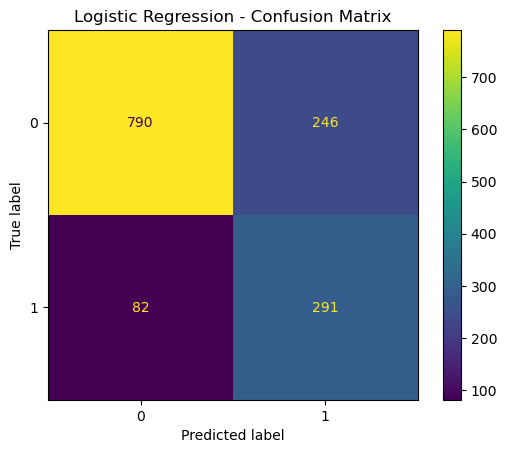

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1036
           1       0.49      0.56      0.52       373

    accuracy                           0.73      1409
   macro avg       0.66      0.67      0.67      1409
weighted avg       0.74      0.73      0.73      1409



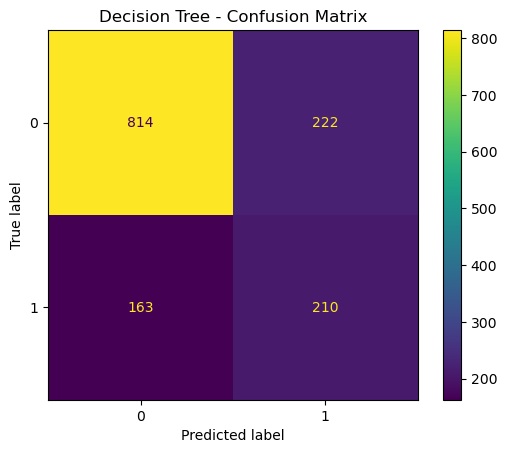

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1036
           1       0.56      0.64      0.60       373

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.79      0.77      0.78      1409



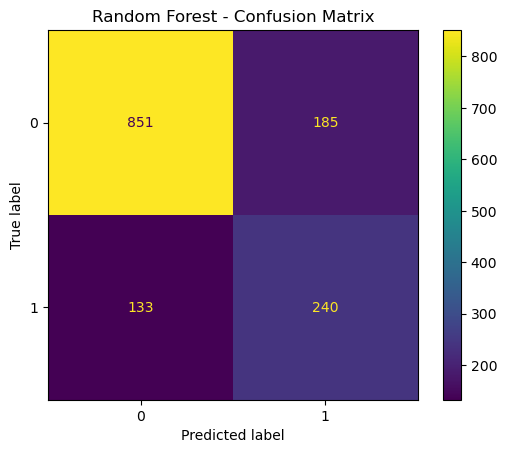

Xgboost Classification Report
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1036
           1       0.55      0.66      0.60       373

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409



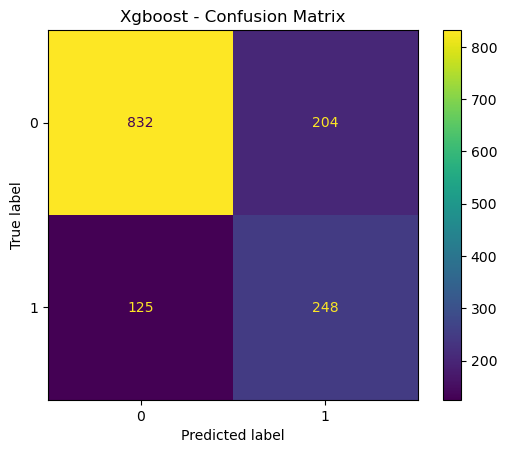

In [17]:
for name, model in models.items():
    print(f"{name} Classification Report")
    y_pred = model.predict(X_test)
    
    # Classification report
    print(metrics.classification_report(y_test, y_pred))
    
    # Confusion matrix
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)
    plt.title(f"{name} - Confusion Matrix")
    plt.show();

Top 10 Features - Logistic Regression
MonthlyCharges                    7.239733
InternetService_Fiber optic       5.329784
PhoneService                      3.780477
StreamingTV_Yes                   2.292411
StreamingMovies_Yes               2.158857
OnlineSecurity_Yes                1.992437
Contract_Two year                 1.805601
TechSupport_Yes                   1.787924
OnlineBackup_Yes                  1.618518
MultipleLines_No phone service    1.602722
dtype: float64


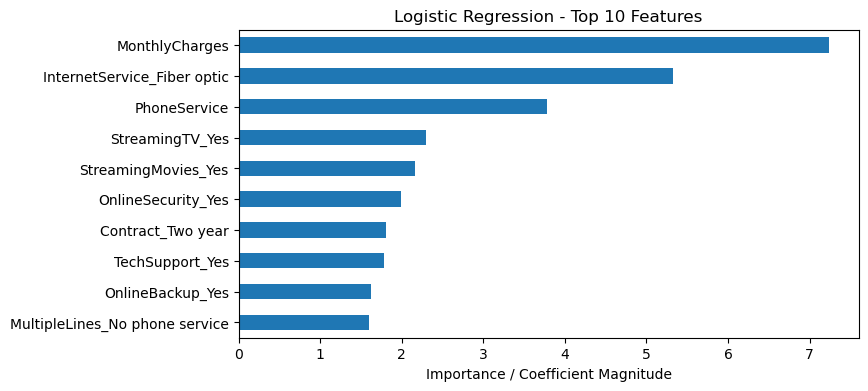

Top 10 Features - Decision Tree
MonthlyCharges                 0.174298
Contract_Two year              0.157619
tenure                         0.129691
TotalCharges                   0.126479
Contract_One year              0.111270
InternetService_Fiber optic    0.033344
gender                         0.028718
PaperlessBilling               0.022087
Dependents                     0.019565
Partner                        0.019278
dtype: float64


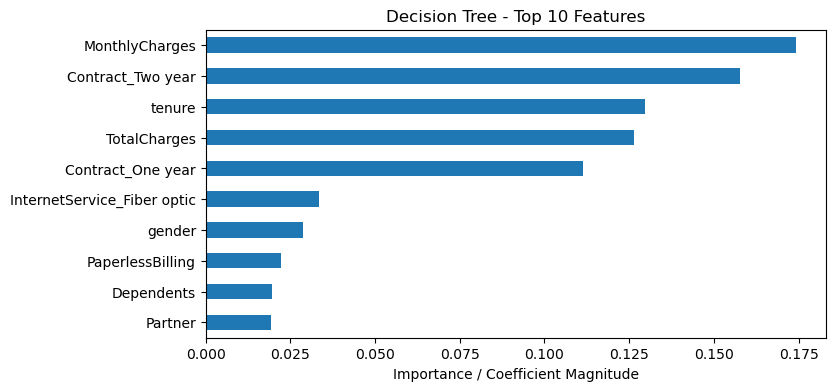

Top 10 Features - Random Forest
TotalCharges                      0.162704
tenure                            0.160087
MonthlyCharges                    0.151553
Contract_Two year                 0.062186
OnlineSecurity_Yes                0.044037
Contract_One year                 0.037518
InternetService_Fiber optic       0.032780
PaymentMethod_Electronic check    0.032605
TechSupport_Yes                   0.027521
gender                            0.024937
dtype: float64


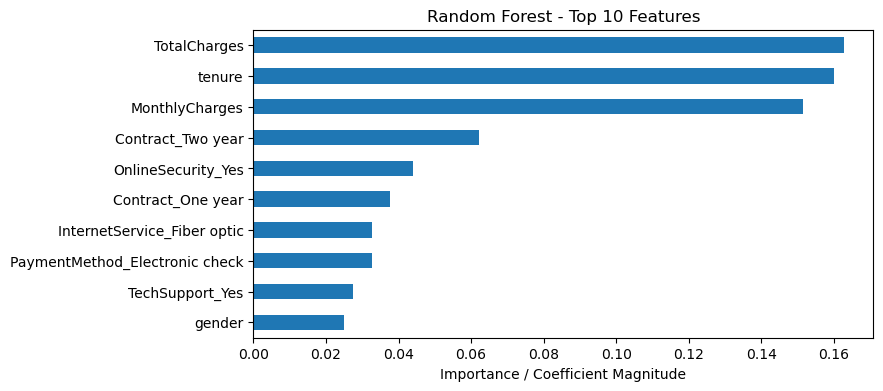

Top 10 Features - Xgboost
Contract_Two year                        0.323238
Contract_One year                        0.180153
InternetService_No                       0.139112
InternetService_Fiber optic              0.097023
PhoneService                             0.023178
OnlineSecurity_Yes                       0.021476
tenure                                   0.018086
TechSupport_Yes                          0.016367
PaymentMethod_Credit card (automatic)    0.015907
PaymentMethod_Mailed check               0.015268
dtype: float32


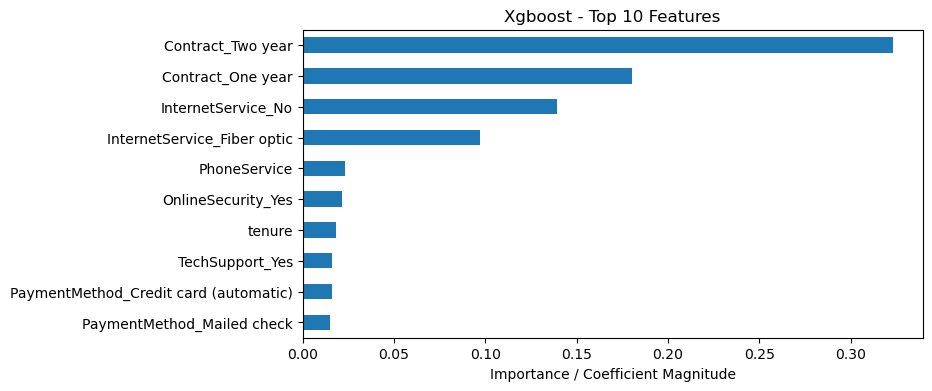

In [18]:
feature_importances = {}

for name, model in models.items():
    # Get feature importance or coefficient magnitudes
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        importances = np.abs(model.coef_[0])

    # Store in dictionary (inside loop!)
    feature_importances[name] = pd.Series(importances, index=X_train_over.columns).sort_values(ascending=False)

# Display top 10 features per model
for name, importances in feature_importances.items():
    print(f"Top 10 Features - {name}")
    print(importances.head(10))
    
    # Plot
    importances.head(10).plot(kind='barh', figsize=(8,4))
    plt.gca().invert_yaxis()
    plt.title(f"{name} - Top 10 Features")
    plt.xlabel("Importance / Coefficient Magnitude")
    plt.show()


In [19]:
#Hyperparameter tuning for all models
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state = 42, max_iter = 1000),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "solver": ["lbfgs", "liblinear", "saga"],
            "penalty": ["l2", "l1"]
        }
    },
    "Decision Tree": {
    "model": DecisionTreeClassifier(random_state=42),
    "params": {
        "criterion": ["gini", "entropy"],              
        "max_depth": [3, 5, 10, 20, None],      
        "min_samples_split": [2, 5, 10],           
        "min_samples_leaf": [1, 2, 4],           
        "max_features": ["sqrt", "log2", None]        
        }
    },
    "Random Forest": {
    "model": RandomForestClassifier(random_state=42),
    "params": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
       }
   },
    "XGBoost": {
    "model": xgb.XGBClassifier(random_state=42),
    "params": {
        "objective": ['binary:logistic'], 
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1, 0.2], 
        "max_depth": [3,5],
        "subsample": [0.7, 1.0],
        "colsample_bytree": [0.7, 1.0]
        }
    }
}

In [20]:
# RunHyperparameterTuning
best_models = {}

for name, mp in param_grids.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(estimator = mp["model"], param_grid = mp["params"], scoring = "roc_auc", cv = 5, n_jobs = -1, verbose = 1)
    grid.fit(X_train_over, y_train_over)
    
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best roc_auc: {grid.best_score_:.2f}\n")
    
    best_models[name] = grid.best_estimator_

Tuning Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best roc_auc: 0.88

Tuning Decision Tree...
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best params for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best roc_auc: 0.84

Tuning Random Forest...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best roc_auc: 0.92

Tuning XGBoost...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.7}
Best roc_auc: 0.90




Logistic Regression - Tuned Model Performance
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1036
           1       0.55      0.77      0.64       373

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409



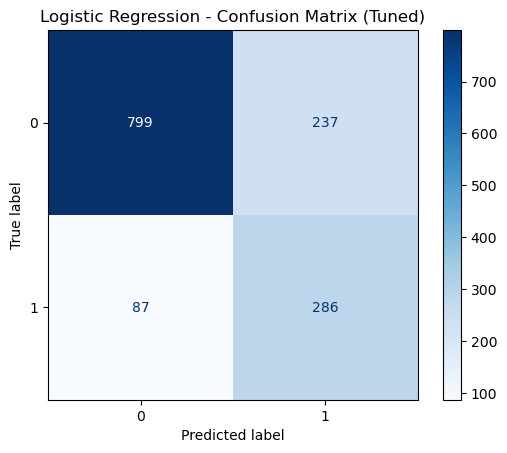


Decision Tree - Tuned Model Performance
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1036
           1       0.50      0.81      0.62       373

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409



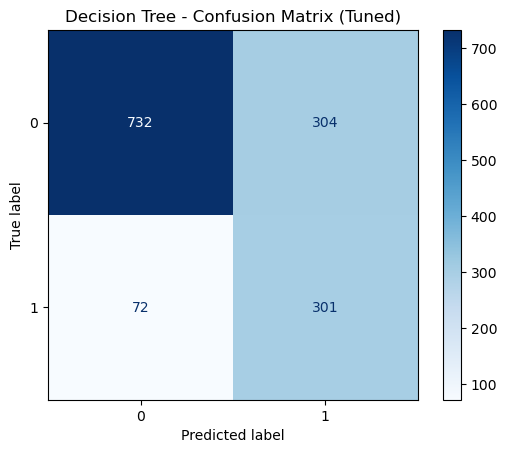


Random Forest - Tuned Model Performance
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1036
           1       0.57      0.66      0.61       373

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409



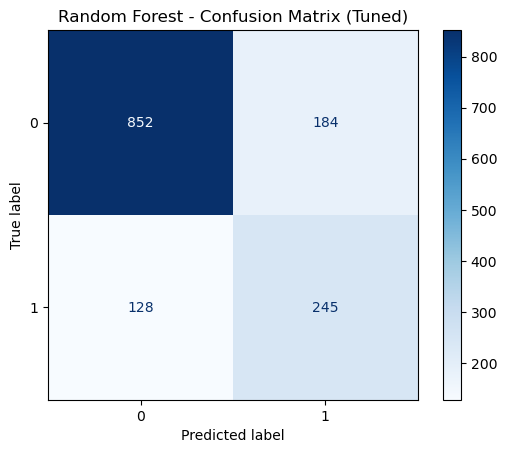


XGBoost - Tuned Model Performance
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1036
           1       0.56      0.67      0.61       373

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.77      0.78      1409



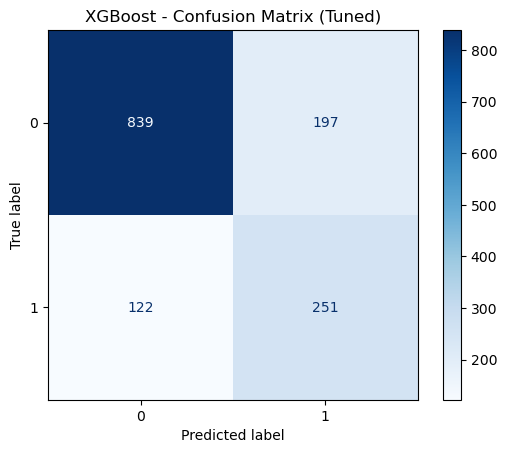

In [21]:
# EvaluateTunedModels
for name, model in best_models.items():
    print(f"\n{name} - Tuned Model Performance")
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))
    
    metrics.ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap = 'Blues')
    plt.title(f"{name} - Confusion Matrix (Tuned)")
    plt.show()

Logistic Regression (untuned) model trained successfully
Logistic Regression (tuned) model trained successfully
Decision Tree (untuned) model trained successfully
Decision Tree (tuned) model trained successfully
Random Forest (untuned) model trained successfully
Random Forest (tuned) model trained successfully
XGBoost (untuned) model trained successfully
XGBoost (tuned) model trained successfully


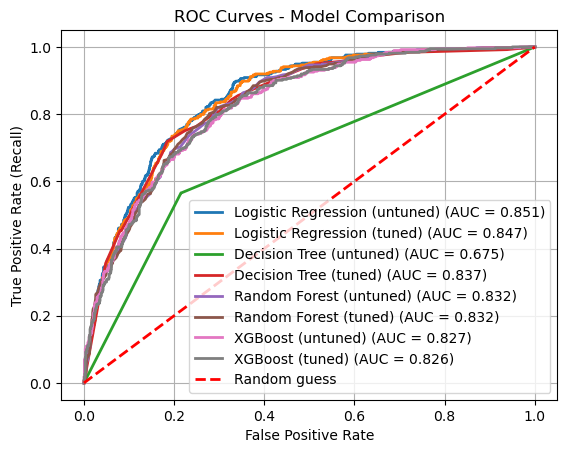

In [22]:
# models
models = {
    "Logistic Regression (untuned)": LogisticRegression(random_state=42, max_iter=1000).fit(X_train_over, y_train_over),
    "Logistic Regression (tuned)": best_models["Logistic Regression"],
    "Decision Tree (untuned)": DecisionTreeClassifier(random_state=42).fit(X_train_over, y_train_over),
    "Decision Tree (tuned)": best_models["Decision Tree"],
    "Random Forest (untuned)": RandomForestClassifier(random_state=42).fit(X_train_over, y_train_over),
    "Random Forest (tuned)": best_models["Random Forest"],
    "XGBoost (untuned)": xgb.XGBClassifier(random_state=42, objective='binary:logistic').fit(X_train_over, y_train_over),
    "XGBoost (tuned)": best_models["XGBoost"]
}

# Train models on oversampled training data
for name, model in models.items():
    model.fit(X_train_over, y_train_over)
    print(f"{name} model trained successfully")
    
# Loop through each model to compute ROC and AUC
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # for class 1
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw = 2, label = f'{name} (AUC = {roc_auc:.3f})')

# Plot random guess line
plt.plot([0,1], [0,1], color = 'red', lw = 2, linestyle = '--', label = 'Random guess')

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

**The ROC curves concludes that both the untuned and tuned Logistic Regression (AUC = 0.851 and 0.847) are the best models for identifying at-risk customers, based on their recall and AUC values**